## Test SIFT detector

In [33]:
# A bit of setup
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Set global variables
data_dir = 'data/FLIC-full' # store image 
train_fn = '%s/train_joints.csv' % data_dir # store corrdinates of joints for training data
train_dl = np.array([l.strip() for l in open(train_fn).readlines()])
N_train = train_dl.shape[0]
print 'Number of training data', N_train

Number of training data 17380


## Set up transform to crop and resize image, but don't do local contrast normalization

In [35]:
# Choose num_test images from traning set
from my_scripts.transform import Transform
from my_scripts.test_flic_dataset import draw_joints
num_test = 3
num_bounding_box = 5
trans_tests = train_dl[np.random.choice(N_train, num_test)]
# transfrom parameters
pad_inf = 1 # infimum scale
pad_sup = 1.5 # supremum scale
size = 220 # resize size
shift = 3 # radomly shift the bounding box
lcn = False # local contrast normalization
num_joints = 7
result_dir = 'test_results'
trans = Transform(pad_inf,
                  pad_sup,
                  size=size, 
                  shift=shift, 
                  lcn=lcn)

## Plot random transformed images for testing transform

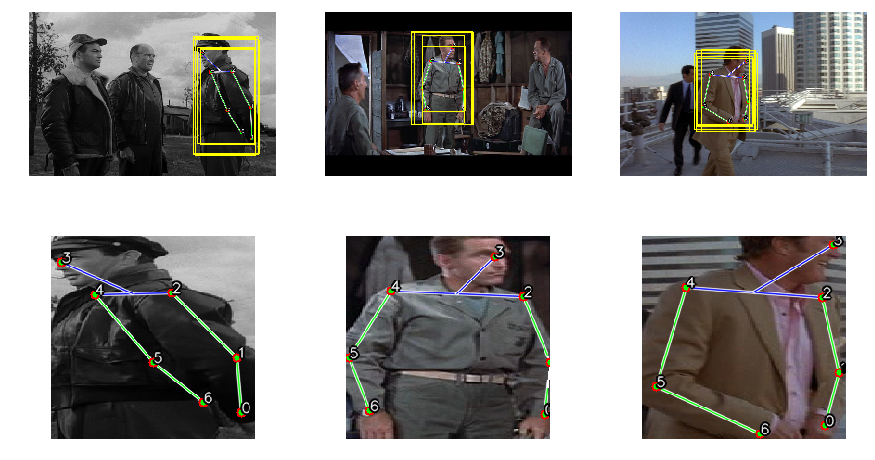

In [36]:
# plot the images
ori_imgs = np.zeros((num_test, 480, 720, 3))
ori_labels = np.zeros((num_test, num_joints * 2))
tran_imgs = np.zeros((num_test, size, size, 3))
tran_labels = np.zeros((num_test, num_joints * 2))
bound_box_params = [] 

for i, x in enumerate(trans_tests):
    x = x.strip().split(',')
    img_file_name = '%s/images/%s' % (data_dir, x[0])
    ori_joints = np.array([int(float(p)) for p in x[1:]])
    ori_img = cv.imread(img_file_name)
    # draw joints
    draw_ori_joints = zip(ori_joints[0::2], ori_joints[1::2])
    ori_img_joints = draw_joints(ori_img.copy(), draw_ori_joints)
    
    # get bounding box
    for j in xrange(num_bounding_box):
        trans._img = ori_img
        trans._joints = ori_joints
        x, y, w, h = trans.crop()
        # draw bouding box
        cv.rectangle(ori_img_joints, (x, y), (x + w, y+h), (0, 255, 255), thickness=2)
        
    ori_imgs[i] = ori_img_joints
    # draw bounding box
    
    # tranformation
    tran_img, tran_joints = trans.transform(img_file_name, ori_img.copy(), ori_joints.copy())
    tran_img, tran_joints = trans.revert(tran_img, tran_joints)
    draw_tran_joints = [tuple(p) for p in tran_joints] # must tuple in opencv
    tran_imgs[i] = draw_joints(tran_img.copy(), draw_tran_joints)
#     tran_imgs[i] = tran_img
for y in xrange(2):
    for i in xrange(num_test):
        plt_idx = y * num_test + i + 1
        plt.subplot(2, num_test, plt_idx)
        if y == 0:
            b,g,r = cv.split(ori_imgs[i])       # get b,g,r
        else:
            b,g,r = cv.split(tran_imgs[i])
        rgb_img = cv.merge([r,g,b])   
        plt.imshow(rgb_img.astype('uint8'))
        plt.axis('off')
plt.show()

## Compute all the sift feature for all training data

In [5]:
from my_scripts.sift_extracted import extract_sift_one_img
from progressbar import ProgressBar
kp_results = []
train_dl = train_dl[0:100]
N = len(train_dl)
pbar = ProgressBar(N)
for i, x in enumerate(train_dl):
    x = x.strip().split(',')
    img_file_name = '%s/images/%s' % (data_dir, x[0])
    ori_img = cv.imread(img_file_name)
    ori_joints = np.array([int(float(p)) for p in x[1:]])
    
    # transform
    tran_img, _ = trans.transform(img_file_name, ori_img.copy(), ori_joints.copy())
    # compute SIFT
    kp, des, kp_img = extract_sift_one_img(tran_img, descriptor=False, draw_kp=False)
    kp_results.append(kp)
    pbar.update(i+1)
pbar.finish()
    

100% (100 of 100) |#######################| Elapsed Time: 0:00:02 Time: 0:00:02


## Plot the distribution of the number of keypoints for each image

stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.
/Users/houxianxu/anaconda/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'rows' keyword is deprecated, use 'index' instead
  warnings.warn(msg, FutureWarning)


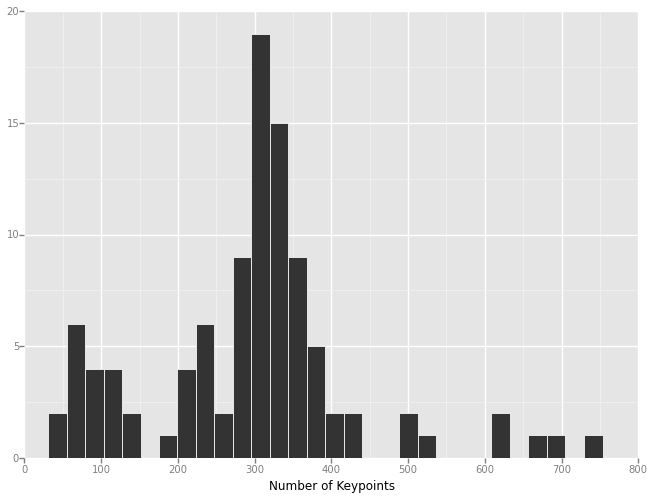

<ggplot: (285171801)>

In [6]:
from ggplot import *
import pandas as pd
num_kps = [len(x) for x in kp_results]
df_kps = pd.DataFrame({'num_kps': num_kps})
gg = ggplot(df_kps, aes('num_kps')) + geom_histogram()
gg += labs(x = "Number of Keypoints")
gg

## Plot SIFT keypoints on transformed images

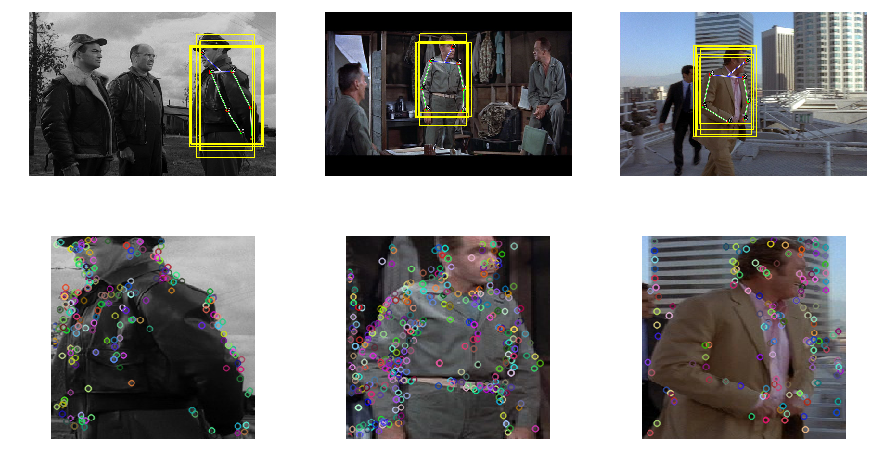

In [37]:
# plot the images
ori_imgs = np.zeros((num_test, 480, 720, 3))
ori_labels = np.zeros((num_test, num_joints * 2))
kp_imgs = np.zeros((num_test, size, size, 3))
tran_labels = np.zeros((num_test, num_joints * 2))
bound_box_params = [] 

for i, x in enumerate(trans_tests):
    x = x.strip().split(',')
    img_file_name = '%s/images/%s' % (data_dir, x[0])
    ori_joints = np.array([int(float(p)) for p in x[1:]])
    ori_img = cv.imread(img_file_name)
    # draw joints
    draw_ori_joints = zip(ori_joints[0::2], ori_joints[1::2])
    ori_img_joints = draw_joints(ori_img.copy(), draw_ori_joints)
    
    # get bounding box
    for j in xrange(num_bounding_box):
        trans._img = ori_img
        trans._joints = ori_joints
        x, y, w, h = trans.crop()
        # draw bouding box
        cv.rectangle(ori_img_joints, (x, y), (x + w, y+h), (0, 255, 255), thickness=2)
        
    ori_imgs[i] = ori_img_joints
    # draw bounding box
    
    # tranformation
    tran_img, tran_joints = trans.transform(img_file_name, ori_img.copy(), ori_joints.copy())
    tran_img, _ = trans.transform(img_file_name, ori_img.copy(), ori_joints.copy())
    # compute SIFT
    kp, des, kp_img = extract_sift_one_img(tran_img, descriptor=False, draw_kp=True)
    kp_imgs[i] = kp_img
    
for y in xrange(2):
    for i in xrange(num_test):
        plt_idx = y * num_test + i + 1
        plt.subplot(2, num_test, plt_idx)
        if y == 0:
            b,g,r = cv.split(ori_imgs[i])       # get b,g,r
        else:
            b,g,r = cv.split(kp_imgs[i])
        rgb_img = cv.merge([r,g,b])   
        plt.imshow(rgb_img.astype('uint8'))
        plt.axis('off')
plt.show()

## Use bag of word to get features for training

In [14]:
import cv2 as cv
extract = cv.DescriptorExtractor_create('SIFT')
flann_params = dict(algorithm = 0, trees = 5)      # flann enums are missing, FLANN_INDEX_KDTREE=1
matcher = cv.FlannBasedMatcher(flann_params, {})

## 1.a setup BOW
bow_train = cv.BOWKMeansTrainer(500)
bow_extract = cv.BOWImgDescriptorExtractor(extract, matcher)

## add descriptor to bow_train
train_dl = train_dl[0:100]
N = len(train_dl)
pbar = ProgressBar(N)
for i, x in enumerate(train_dl):
    x = x.strip().split(',')
    img_file_name = '%s/images/%s' % (data_dir, x[0])
    ori_img = cv.imread(img_file_name)
    ori_joints = np.array([int(float(p)) for p in x[1:]])
    
    # transform
    tran_img, _ = trans.transform(img_file_name, ori_img.copy(), ori_joints.copy())
    # compute SIFT
    _, des, _ = extract_sift_one_img(tran_img, descriptor=True, draw_kp=False)
    bow_train.add(des)
    pbar.update(i+1)
pbar.finish()
print('houxianxu')


 99% (99 of 100) |####################### | Elapsed Time: 0:00:04 ETA:  0:00:00

houxianxu


100% (100 of 100) |#######################| Elapsed Time: 0:00:04 Time: 0:00:04


In [15]:
## compute vocabulary
vocabulary = bow_train.cluster()
bow_extract.setVocabulary(vocabulary)
print 'Bow vocabulary:', np.shape(vocabulary)

Bow vocabulary: (500, 128)


In [25]:
a = bow_extract.compute(tran_img, extract_sift_one_img(tran_img)[0])

In [28]:
help(bow_extract)

Help on BOWImgDescriptorExtractor object:

class BOWImgDescriptorExtractor(__builtin__.object)
 |  Methods defined here:
 |  
 |  __repr__(...)
 |      x.__repr__() <==> repr(x)
 |  
 |  compute(...)
 |      compute(image, keypoints[, imgDescriptor]) -> imgDescriptor
 |  
 |  descriptorSize(...)
 |      descriptorSize() -> retval
 |  
 |  descriptorType(...)
 |      descriptorType() -> retval
 |  
 |  getVocabulary(...)
 |      getVocabulary() -> retval
 |  
 |  setVocabulary(...)
 |      setVocabulary(vocabulary) -> None
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __new__ = <built-in method __new__ of type object>
 |      T.__new__(S, ...) -> a new object with type S, a subtype of T

